## Import libraries
Sources: https://colab.research.google.com/drive/1mm9r6EZOERHYkycDbc74GY7S2U6h1oTc#scrollTo=oWMehM7UFpvj

https://github.com/Finance-781/FinML/blob/master/Lecture%207%20-%20Principal%20Components/Inclass/Lecture%207%20-%20dimensionality_reduction%20-%20Inclass.ipynb

In [47]:
from matplotlib import style
import seaborn as sns
from scipy.stats import randint as sp_randint
from sklearn.decomposition import PCA
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.cluster.hierarchy import dendrogram


%matplotlib inline
style.use("ggplot")


## Import Files

In [23]:
%store -r asset_12

In [24]:
asset_12.head(2)

,IVV,EFA,EEM,VIG,SHY,LQD,EMB,MUB,TIP,VNQ,XLE,GLD
Date,,,,,,,,,,,,
2009-06-01,77.035706,34.372078,27.405502,32.856422,75.464882,65.979172,57.978580,75.367775,79.87307,22.627659,41.031338,93.709999
2009-06-08,77.466110,35.200672,27.511499,32.952915,75.637337,67.205452,57.947876,74.506866,80.43000,22.154604,42.133686,92.169998


In [25]:
# Copying the dataframe to add features
data = pd.DataFrame(asset_12.copy())

In [26]:
# Daily Linear Returns (%)
datareturns = data.pct_change(1)


In [27]:
# Portfolio Equal Weighted rETURN
datareturns["Portfolio"] = datareturns.mean(axis=1)


In [28]:
# Data Raw
data_raw = datareturns
data_raw.dropna(how='all', inplace=True)

In [29]:
# Normalizing the returns
data = (data_raw - data_raw.mean()) / data_raw.std()


In [30]:
# Getting rid of the NaN values.
data.dropna(how='any', inplace=True)
data_raw.dropna(how='any', inplace=True)


In [31]:
data.head(3)

,IVV,EFA,EEM,VIG,SHY,LQD,EMB,MUB,TIP,VNQ,XLE,GLD,Portfolio
Date,,,,,,,,,,,,,
2009-06-08,0.146372,0.964096,0.095858,0.026667,1.399900,2.182235,-0.165827,-1.905320,0.870231,-0.883867,0.867598,-0.831314,0.177762
2009-06-15,-1.464913,-1.375753,-2.119054,-1.557833,1.073449,-0.691870,-1.283607,0.208574,-0.181051,-2.604987,-2.745001,-0.177666,-2.269606
2009-06-22,-0.577889,-0.938058,0.592243,-0.520741,2.283695,2.179112,0.091665,0.632808,0.900156,-0.816086,-0.773763,0.169530,-0.249176


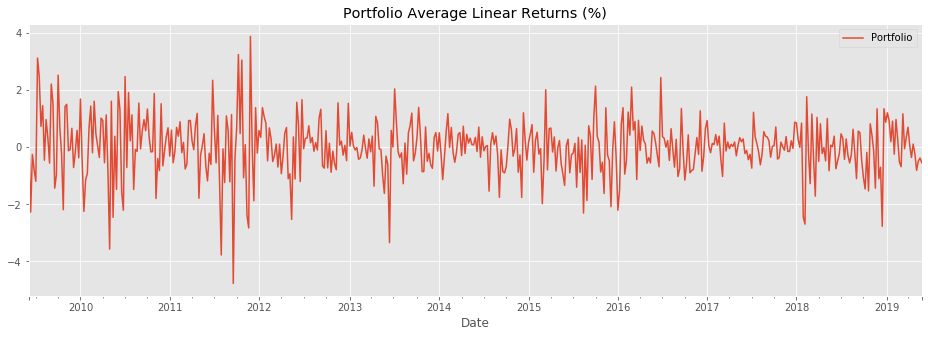

In [32]:
# Visualizing Log Returns for the portfolio

plt.figure(figsize=(16, 5))
plt.title("Portfolio Average Linear Returns (%)")
data.Portfolio.plot()
plt.grid(True);
plt.legend()
plt.show()

In [33]:
# Taking away the portfolio benchmark 
stock_tickers = data.columns.values[:-1]
n_tickers = len(stock_tickers)


In [34]:
# Dividing the dataset into training and testing sets
percentage = int(len(data) * 0.7)
X_train = data[:percentage]
X_test = data[percentage:]

X_train_raw = data_raw[:percentage]
X_test_raw = data_raw[percentage:]


In [35]:
# Applying Principle Component Analysis
# Creating covariance matrix and training data on PCA.
cov_matrix = X_train.loc[:,X_train.columns != 'Portfolio'].cov()
pca = PCA()
pca.fit(cov_matrix)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

4 principal components explain 97.00% of variance


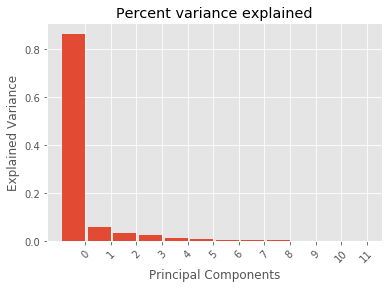

In [37]:
def plotPCA(plot=False):

    # Visualizing Variance against number of principal components.
    cov_matrix_raw = X_train_raw.loc[:,X_train_raw.columns != 'Portfolio'].cov()

    var_threshold = 0.97
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  

    if plot:
        print('%d principal components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

        # PCA percent variance explained.
        bar_width = 0.9
        n_asset = stock_tickers.shape[0]
        x_indx = np.arange(n_asset)
        fig, ax = plt.subplots()

        # Eigenvalues measured as percentage of explained variance.
        rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width)
        ax.set_xticks(x_indx + bar_width / 2)
        ax.set_xticklabels(list(range(n_asset)), rotation=45)
        ax.set_title('Percent variance explained')
        ax.set_ylabel('Explained Variance')
        ax.set_xlabel('Principal Components')
        plt.show()

plotPCA(plot=True)

In [38]:
projected = pca.fit_transform(cov_matrix)
pcs = pca.components_

In [39]:
# Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=52):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe


Eigen portfolio #2 with the highest Sharpe. Return nan%, vol = 366.59%, Sharpe = nan
          Return        Vol        Sharpe
8   6.547972e+14  25.404518  2.577483e+13
9   1.443141e+03  12.861583  1.122056e+02
7   1.244208e+01  14.978890  8.306407e-01
6   4.204717e-01   0.579493  7.255851e-01
10  2.130359e-01   0.911953  2.336041e-01
4   2.744551e-02   0.598210  4.587940e-02
3   1.566164e-02   0.780273  2.007201e-02
0  -9.573468e-02   1.392982 -6.872643e-02
1  -9.995575e-01   4.313668 -2.317187e-01


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


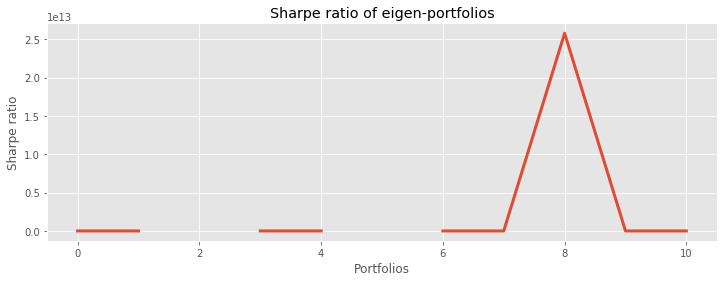

In [40]:
def optimizedPortfolio():
    n_portfolios = len(pcs)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 

    for i in range(n_portfolios):
        
        pc_w = pcs[:, i] / sum(pcs[:, i])
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        
        eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen_prtfi / n_portfolios)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe

    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(10))

    plt.show()

optimizedPortfolio()

Sum of weights of current eigen-portfolio: 100.00


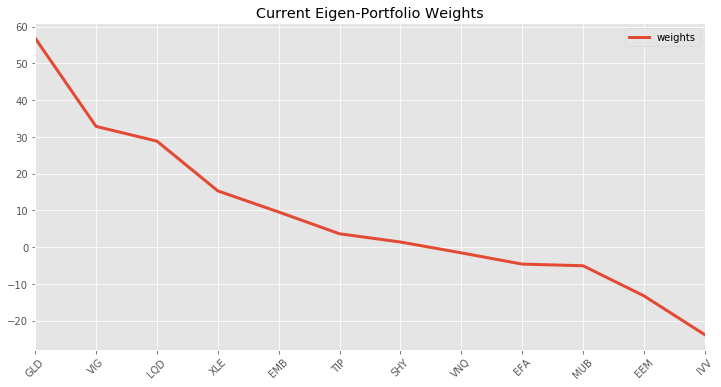

,weights
GLD,56.820625
VIG,32.833859
LQD,28.827704
XLE,15.289591
EMB,9.551826
TIP,3.625435
SHY,1.384025
VNQ,-1.561072
EFA,-4.621471
MUB,-5.066685


In [41]:
def PCWeights():
    '''
    Principal Components (PC) weights for each 28 PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pcs)):
        weights["weights_{}".format(i)] = pcs[:, i] / sum(pcs[:, i])

    weights = weights.values.T
    return weights

weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()

    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights[4], plot=True)

Current Eigen-Portfolio:
Return = 2.74%
Volatility = 59.82%
Sharpe = 0.05


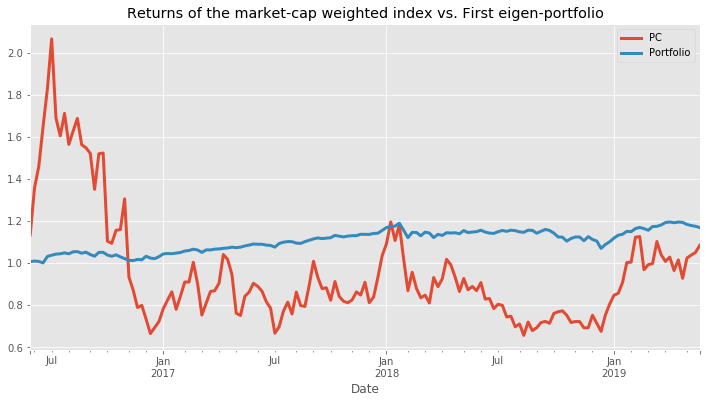

In [42]:
#    Plots Principle components returns against real returns.
def plotSharpe(eigen):
    eigen_portfolio_returns = np.dot(X_test_raw.loc[:, eigen.index], eigen / len(pcs))
    eigen_portfolio_returns = pd.Series(eigen_portfolio_returns.squeeze(), index=X_test.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)
    print('Current Eigen-Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    year_frac = (eigen_portfolio_returns.index[-1] - eigen_portfolio_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC': eigen_portfolio_returns, 'Portfolio': X_test_raw.loc[:, 'Portfolio']}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)
    plt.show()

plotSharpe(eigen=plotEigen(weights=weights[4]))

## Investigating Hierarchal Clustering

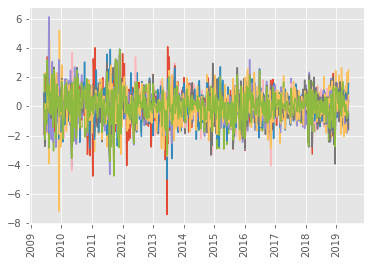

In [43]:
#A messy plot of all the processed adjusted closing prices
plt.plot(data);
plt.xticks(rotation='vertical');

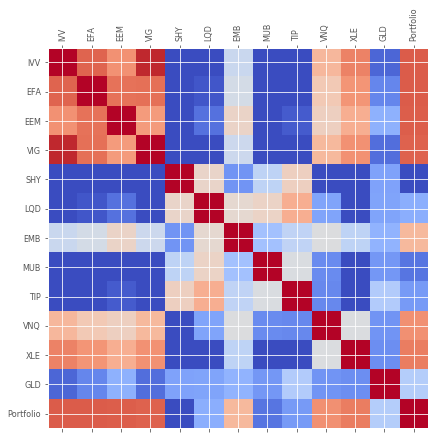

In [44]:
#find correlation matrix, i.e. the "distances" between each stock
corr = data.corr()
size = 7
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(corr,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8);
